In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load MinWage variable

In [170]:
data = pd.read_csv("./minimum wage.csv") 
data['Effective Date'] = pd.to_datetime(data['Effective Date'], format='%d-%b-%y')
data = data.sort_values(by='Effective Date')

data['Minimum Wage'] = data['Minimum Wage'].replace('[\$,]', '', regex=True).astype(float)

monthly_range = pd.date_range(start='2003-01-01', end='2024-09-01', freq='MS')
monthly_df = pd.DataFrame({'date': monthly_range})

data = data.set_index('Effective Date')
monthly_df = monthly_df.merge(data[['Minimum Wage']], how='left', left_on='date', right_index=True)

monthly_df['MinWage'] = monthly_df['Minimum Wage'].ffill().bfill()

monthly_df.loc[monthly_df['date'] < '2011-05-01', 'MinWage'] = 8.00

monthly_df = monthly_df.drop(columns=['Minimum Wage'])

monthly_df.head(1000)

,date,MinWage
0,2003-01-01,8.00
1,2003-02-01,8.00
2,2003-03-01,8.00
3,2003-04-01,8.00
4,2003-05-01,8.00
...,...,...
256,2024-05-01,16.75
257,2024-06-01,17.40
258,2024-07-01,17.40
259,2024-08-01,17.40


## load crime_number variable

In [171]:
crime_data = pd.read_csv("./crimedata_csv_AllNeighbourhoods_AllYears/crimedata_csv_AllNeighbourhoods_AllYears.csv")  # Replace with the actual path

crime_data['date'] = pd.to_datetime(crime_data[['YEAR', 'MONTH']].assign(DAY=1))

monthly_crime_counts = crime_data.groupby('date').size().reset_index(name='crime_number')

monthly_df = monthly_df.merge(monthly_crime_counts, how='left', on='date')

monthly_df['crime_number'] = monthly_df['crime_number'].fillna(0)

monthly_df.head(1000)




,date,MinWage,crime_number
0,2003-01-01,8.00,4926
1,2003-02-01,8.00,4148
2,2003-03-01,8.00,4550
3,2003-04-01,8.00,4759
4,2003-05-01,8.00,5297
...,...,...,...
256,2024-05-01,16.75,3007
257,2024-06-01,17.40,2810
258,2024-07-01,17.40,3053
259,2024-08-01,17.40,2977


In [172]:
cpi_data = pd.read_csv("./1810000601-eng (1).csv", header=0, index_col=0)

cpi_data = cpi_data.T

cpi_data = cpi_data.rename(columns={"All-items 8": "CPI"})

cpi_data = cpi_data.reset_index().rename(columns={"index": "date"})
cpi_data['date'] = pd.to_datetime(cpi_data['date'], format='%b-%y')

cpi_data = cpi_data[['date', 'CPI']]

cpi_data.index.name = "index"

monthly_df = monthly_df.merge(cpi_data, how='left', on='date')

monthly_df.head(1000)

,date,MinWage,crime_number,CPI
0,2003-01-01,8.00,4926,102.4
1,2003-02-01,8.00,4148,102.9
2,2003-03-01,8.00,4550,103.0
3,2003-04-01,8.00,4759,102.3
4,2003-05-01,8.00,5297,102.1
...,...,...,...,...
256,2024-05-01,16.75,3007,160.6
257,2024-06-01,17.40,2810,160.8
258,2024-07-01,17.40,3053,161.2
259,2024-08-01,17.40,2977,161.3


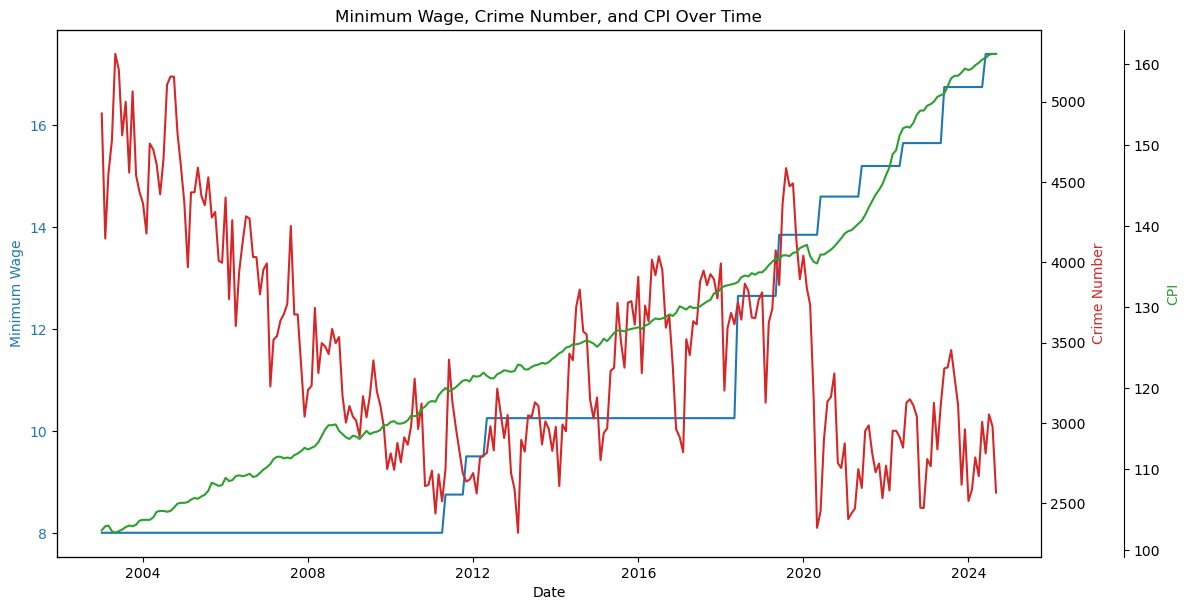

In [173]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Minimum Wage', color=color)
ax1.plot(monthly_df['date'], monthly_df['MinWage'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'

ax2.set_ylabel('Crime Number', color=color)
ax2.plot(monthly_df['date'], monthly_df['crime_number'], color=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('CPI', color=color)
ax3.plot(monthly_df['date'], monthly_df['CPI'], color=color)

fig.tight_layout()
plt.title('Minimum Wage, Crime Number, and CPI Over Time')
plt.show()


## Load temperature variable

In [174]:
temperature_data = pd.read_csv("./temperature.csv", header=None, names=["date", "temperature"])

temperature_data['date'] = pd.to_datetime(temperature_data['date'], format='%Y-%m-%d')

merged_df = pd.merge(monthly_df, temperature_data, how='left', on='date')

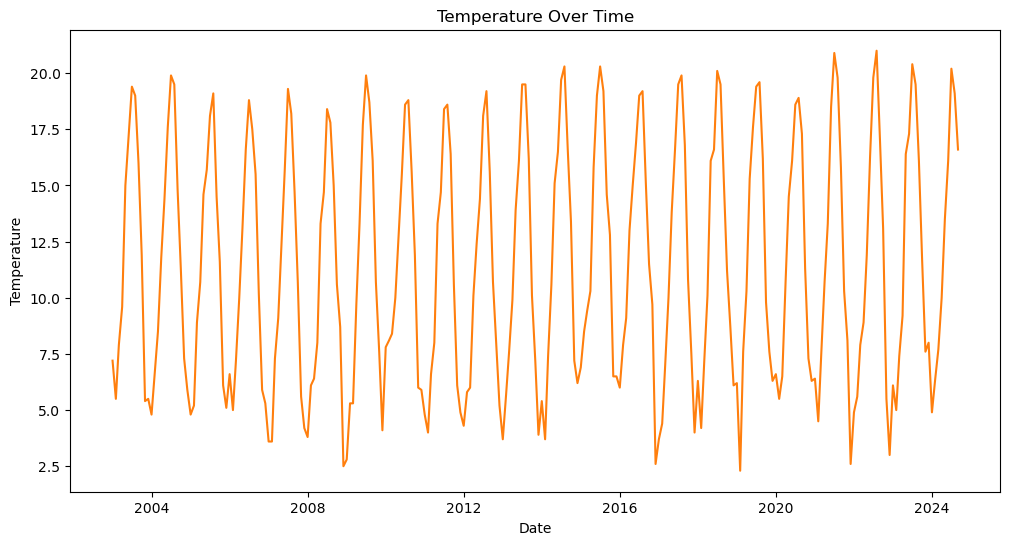

In [175]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['temperature'], color='tab:orange')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()


## Loaded police officer ratio and weighted clearance rate

In [176]:
police_data = pd.read_csv("./unemployment_police.csv")  

police_data['Date'] = pd.to_datetime(police_data['Date'])

police_data.rename(columns={'Date': 'date'}, inplace=True)

merged_df = pd.merge(merged_df, police_data, how='left', on='date')

merged_df.head(6)

,date,MinWage,crime_number,CPI,temperature,"Police officers per 100,000 population",Weighted clearance rate,Vancouver Unemployment Rate
0,2003-01-01,8.0,4926,102.4,7.2,204.2,22.74,7.1
1,2003-02-01,8.0,4148,102.9,5.5,204.2,22.74,7.1
2,2003-03-01,8.0,4550,103.0,7.9,204.2,22.74,7.0
3,2003-04-01,8.0,4759,102.3,9.6,204.2,22.74,7.3
4,2003-05-01,8.0,5297,102.1,15.0,204.2,22.74,7.3
5,2003-06-01,8.0,5199,102.3,17.2,204.2,22.74,6.9


In [177]:
# print the average of crime number, minimum wage, CPI, temperature, unemployment rate, and police number
print("Average of crime number: ", merged_df['crime_number'].mean())
print("Average of minimum wage: ", merged_df['MinWage'].mean())
print("Average of CPI: ", merged_df['CPI'].mean())
print("Average of temperature: ", merged_df['temperature'].mean())

Average of crime number:  3434.015325670498
Average of minimum wage:  10.696360153256707
Average of CPI:  125.5800766283525
Average of temperature:  11.418773946360155


In [178]:
import pandas as pd

def generate_data_description(df):
    stats = df.describe(include='all').transpose()

    stats['unique_values'] = df.nunique()

    stats = stats[['count', 'unique_values', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    
    stats.index.name = 'column_name'

    return stats

data_description = generate_data_description(merged_df)

data_description


/var/folders/qx/5b_gxq5s5fqc9hdq8fcjn60h0000gn/T/ipykernel_45159/2511789111.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  stats = df.describe(include='all').transpose()


,count,unique_values,mean,std,min,25%,50%,75%,max
column_name,,,,,,,,,
date,261,261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MinWage,261.0,11,10.69636,2.960168,8.0,8.0,10.25,12.65,17.4
crime_number,261.0,245,3434.015326,672.739325,2316.0,2913.0,3310.0,3867.0,5297.0
CPI,261.0,206,125.580077,15.707729,102.1,113.7,123.2,135.4,161.3
temperature,261.0,136,11.418774,5.351577,2.3,6.5,10.6,16.2,21.0
"Police officers per 100,000 population",261.0,20,204.136782,15.397368,183.8,191.5,199.1,216.9,234.4
Weighted clearance rate,261.0,19,26.333678,2.262443,22.74,24.53,25.33,27.62,30.85
Vancouver Unemployment Rate,261.0,56,6.164368,1.572723,3.2,4.8,6.5,7.0,14.2


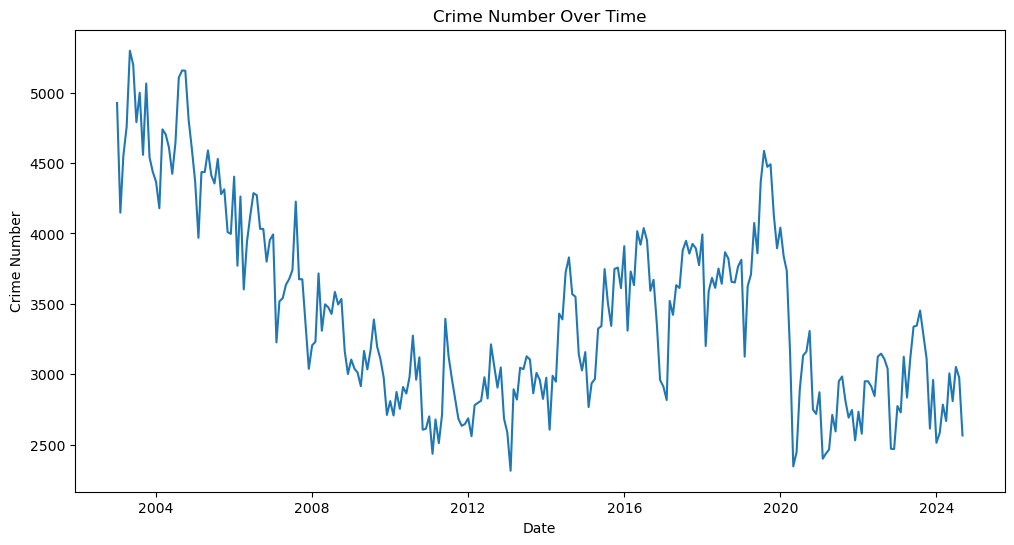

In [179]:
# plot the crime number data over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['crime_number'], color='tab:blue')
plt.title('Crime Number Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Number')
plt.show()

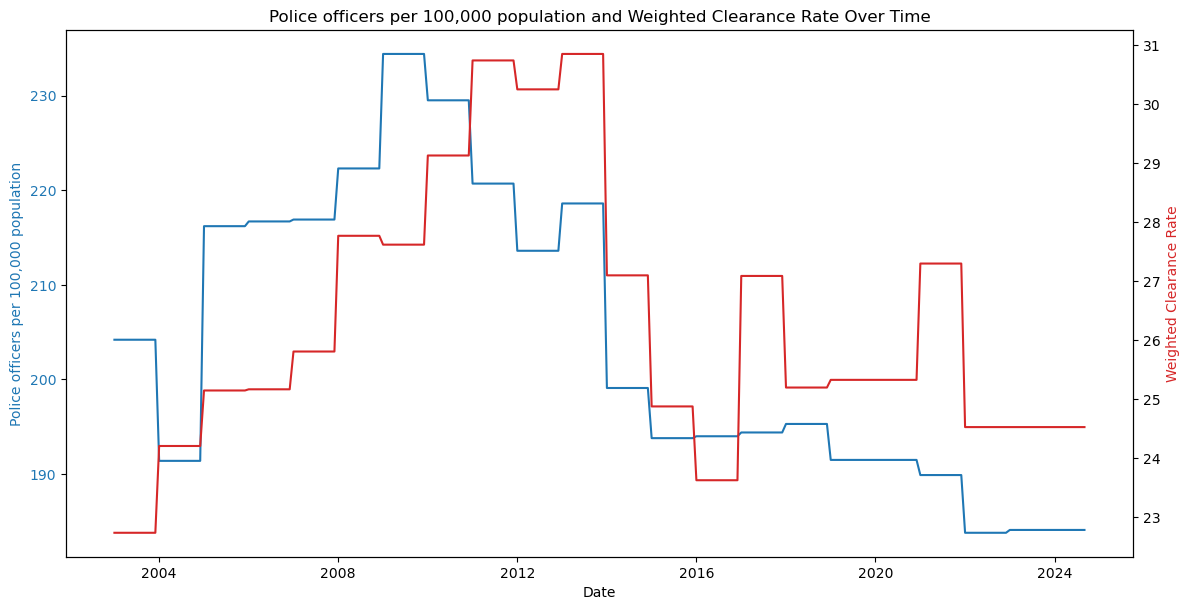

In [180]:
# visualize Police officers per 100,000 population and weighted clearance rate over time
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Police officers per 100,000 population', color=color)
ax1.plot(merged_df['date'], merged_df['Police officers per 100,000 population'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'

ax2.set_ylabel('Weighted Clearance Rate', color=color)
ax2.plot(merged_df['date'], merged_df['Weighted clearance rate'], color=color)

fig.tight_layout()
plt.title('Police officers per 100,000 population and Weighted Clearance Rate Over Time')
plt.show()

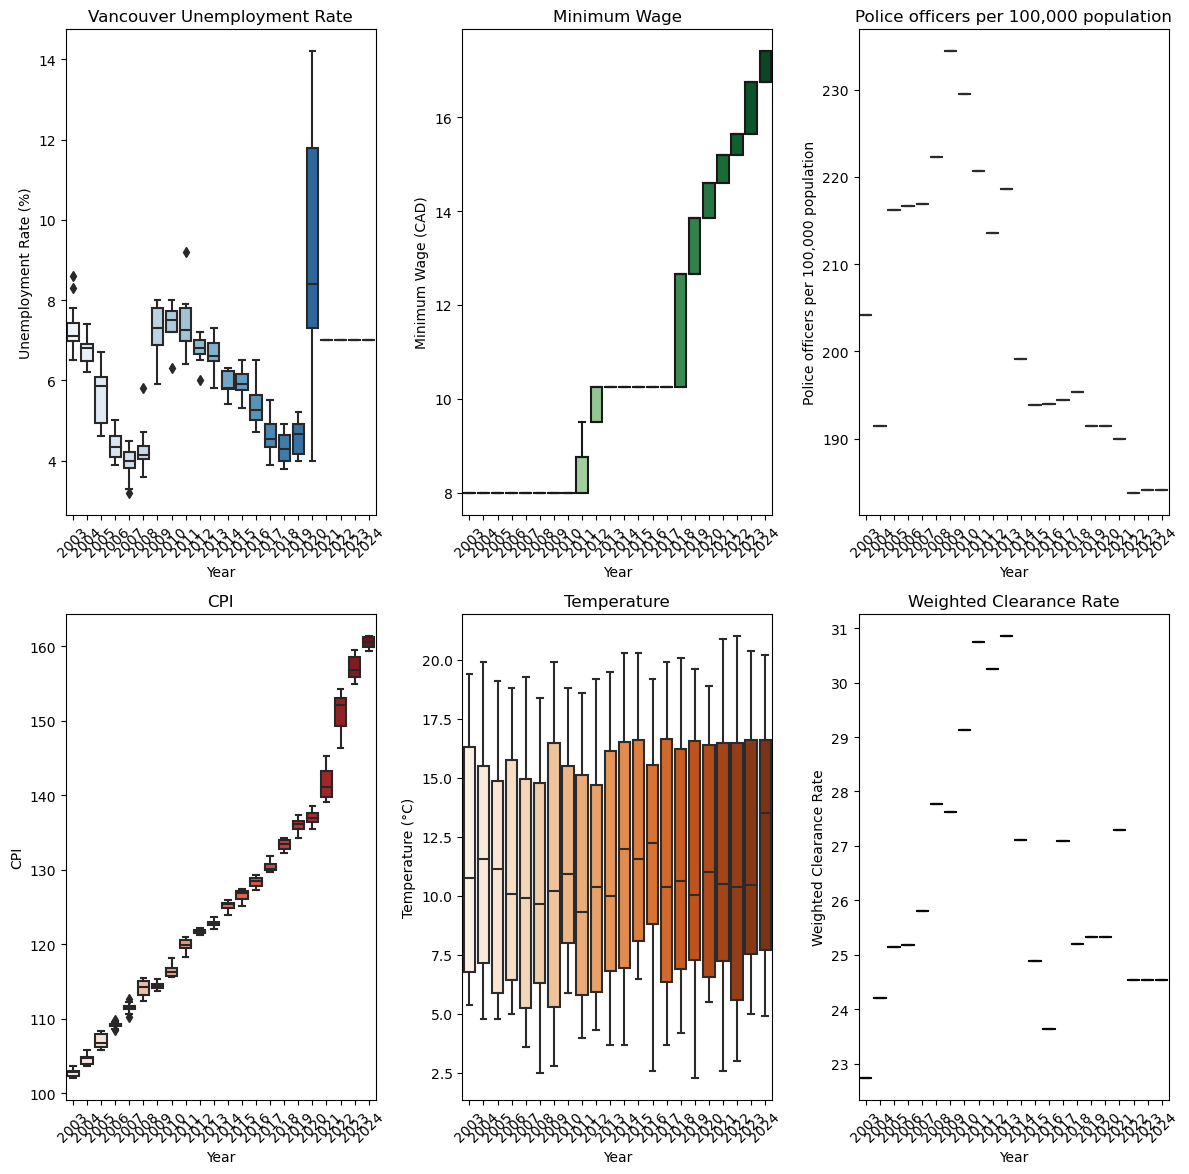

In [181]:
import seaborn as sns

merged_df['year'] = merged_df['date'].dt.year

fig, ax = plt.subplots(2, 3, figsize=(12, 12))

sns.boxplot(data=merged_df, x='year', y='Vancouver Unemployment Rate', ax=ax[0, 0], palette='Blues')
ax[0, 0].set_title('Vancouver Unemployment Rate')
ax[0, 0].set_xlabel('Year')
ax[0, 0].set_ylabel('Unemployment Rate (%)')
ax[0, 0].tick_params(axis='x', rotation=45)

sns.boxplot(data=merged_df, x='year', y='MinWage', ax=ax[0, 1], palette='Greens')
ax[0, 1].set_title('Minimum Wage')
ax[0, 1].set_xlabel('Year')
ax[0, 1].set_ylabel('Minimum Wage (CAD)')
ax[0, 1].tick_params(axis='x', rotation=45)

sns.boxplot(data=merged_df, x='year', y='CPI', ax=ax[1, 0], palette='Reds')
ax[1, 0].set_title('CPI')
ax[1, 0].set_xlabel('Year')
ax[1, 0].set_ylabel('CPI')
ax[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(data=merged_df, x='year', y='temperature', ax=ax[1, 1], palette='Oranges')
ax[1, 1].set_title('Temperature')
ax[1, 1].set_xlabel('Year')
ax[1, 1].set_ylabel('Temperature (°C)')
ax[1, 1].tick_params(axis='x', rotation=45)

sns.boxplot(data=merged_df, x='year', y='Police officers per 100,000 population', ax=ax[0, 2], palette='Purples')
ax[0, 2].set_title('Police officers per 100,000 population')
ax[0, 2].set_xlabel('Year')
ax[0, 2].set_ylabel('Police officers per 100,000 population')
ax[0, 2].tick_params(axis='x', rotation=45)

sns.boxplot(data=merged_df, x='year', y='Weighted clearance rate', ax=ax[1, 2], palette='Greys')
ax[1, 2].set_title('Weighted Clearance Rate')
ax[1, 2].set_xlabel('Year')
ax[1, 2].set_ylabel('Weighted Clearance Rate')
ax[1, 2].tick_params(axis='x', rotation=45)

plt.suptitle('')
plt.tight_layout()

# Show the plot
plt.show()


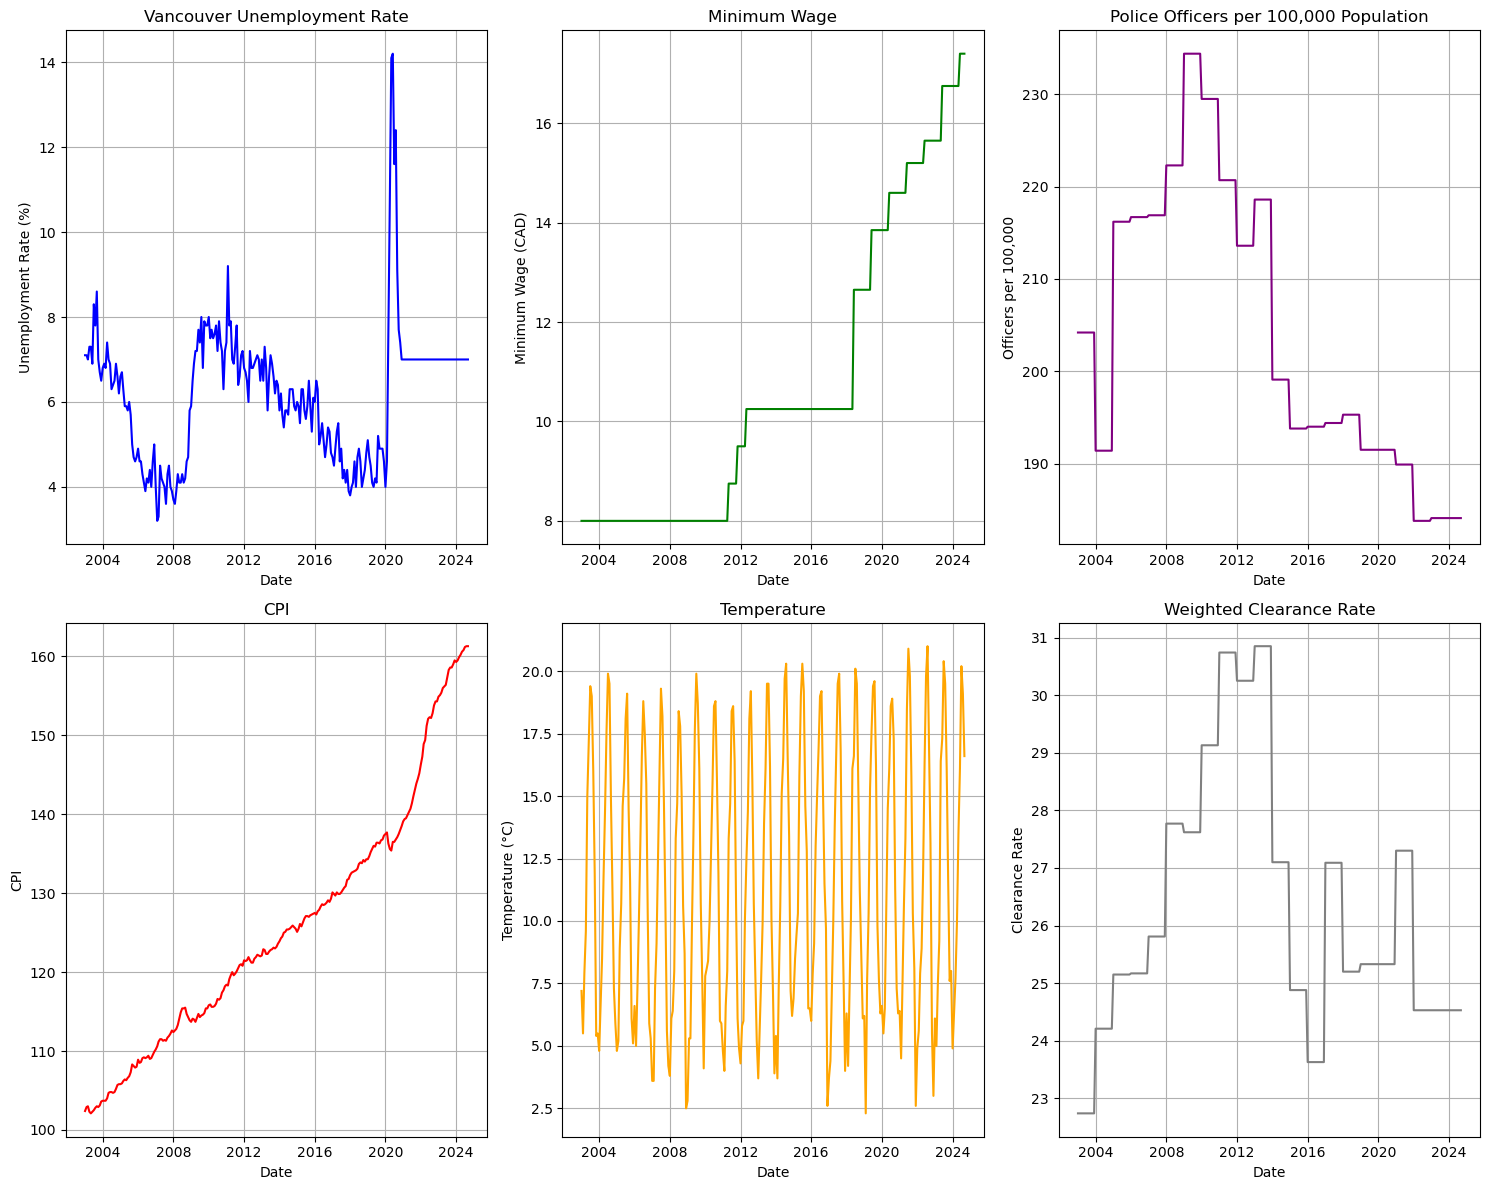

In [182]:
import matplotlib.pyplot as plt

# Create a figure with subplots for each variable
fig, ax = plt.subplots(2, 3, figsize=(15, 12))

# Plot Vancouver Unemployment Rate
ax[0, 0].plot(merged_df['date'], merged_df['Vancouver Unemployment Rate'], label='Vancouver Unemployment Rate', color='blue')
ax[0, 0].set_title('Vancouver Unemployment Rate')
ax[0, 0].set_xlabel('Date')
ax[0, 0].set_ylabel('Unemployment Rate (%)')
ax[0, 0].grid(True)

# Plot Minimum Wage
ax[0, 1].plot(merged_df['date'], merged_df['MinWage'], label='Minimum Wage', color='green')
ax[0, 1].set_title('Minimum Wage')
ax[0, 1].set_xlabel('Date')
ax[0, 1].set_ylabel('Minimum Wage (CAD)')
ax[0, 1].grid(True)

# Plot CPI
ax[1, 0].plot(merged_df['date'], merged_df['CPI'], label='CPI', color='red')
ax[1, 0].set_title('CPI')
ax[1, 0].set_xlabel('Date')
ax[1, 0].set_ylabel('CPI')
ax[1, 0].grid(True)

# Plot Temperature
ax[1, 1].plot(merged_df['date'], merged_df['temperature'], label='Temperature', color='orange')
ax[1, 1].set_title('Temperature')
ax[1, 1].set_xlabel('Date')
ax[1, 1].set_ylabel('Temperature (°C)')
ax[1, 1].grid(True)

# Plot Police officers per 100,000 population
ax[0, 2].plot(merged_df['date'], merged_df['Police officers per 100,000 population'], label='Police officers per 100k population', color='purple')
ax[0, 2].set_title('Police Officers per 100,000 Population')
ax[0, 2].set_xlabel('Date')
ax[0, 2].set_ylabel('Officers per 100,000')
ax[0, 2].grid(True)

# Plot Weighted Clearance Rate
ax[1, 2].plot(merged_df['date'], merged_df['Weighted clearance rate'], label='Weighted Clearance Rate', color='grey')
ax[1, 2].set_title('Weighted Clearance Rate')
ax[1, 2].set_xlabel('Date')
ax[1, 2].set_ylabel('Clearance Rate')
ax[1, 2].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


/var/folders/qx/5b_gxq5s5fqc9hdq8fcjn60h0000gn/T/ipykernel_45159/2648334203.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_avg = merged_df.groupby('month').mean()


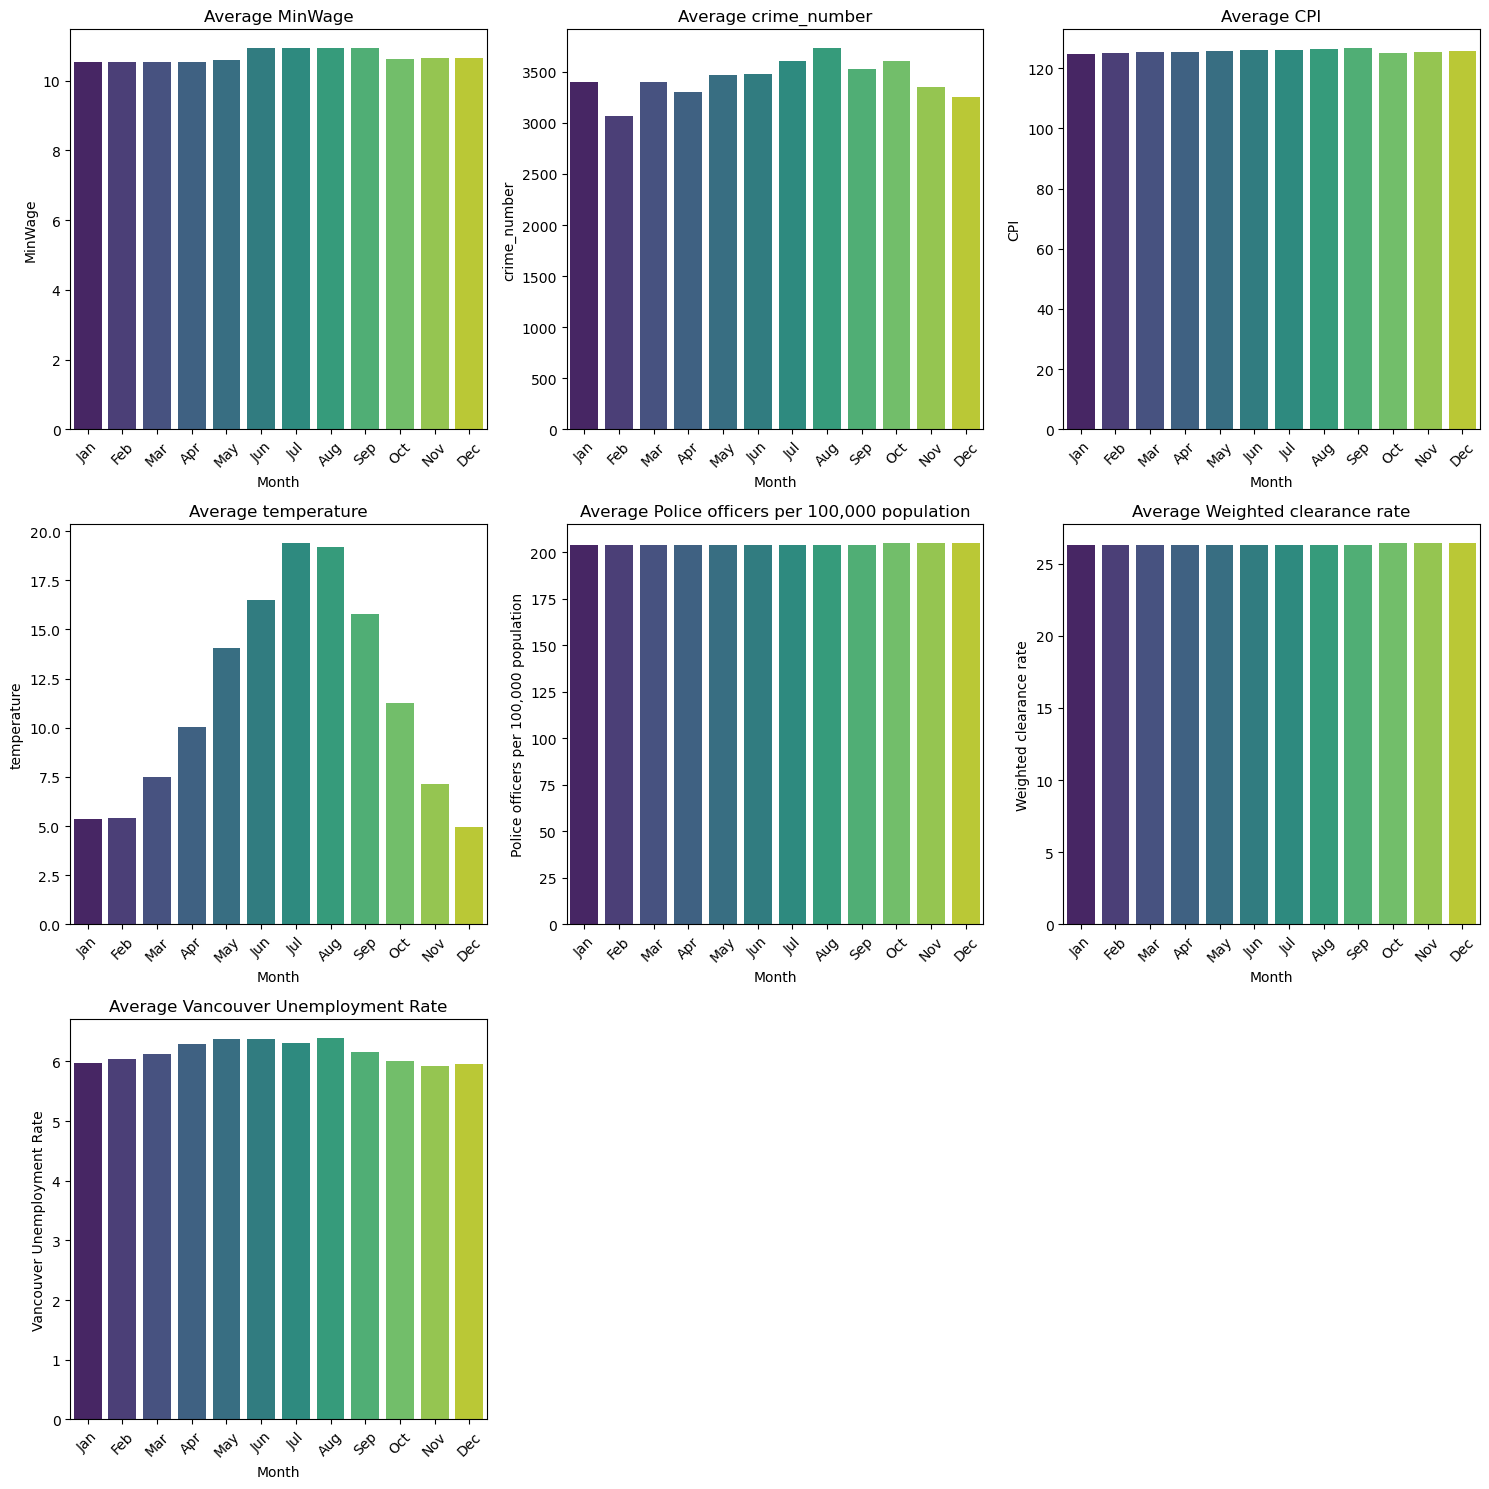

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract month names for better readability
merged_df['month'] = merged_df['date'].dt.month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Group data by month to calculate monthly averages
monthly_avg = merged_df.groupby('month').mean()

# Variables to plot
variables = ['MinWage', 'crime_number', 'CPI', 'temperature', 
             'Police officers per 100,000 population', 'Weighted clearance rate', 
             'Vancouver Unemployment Rate']

# Create a figure with subplots for each variable
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Adjust grid size as needed
axes = axes.flatten()

for i, variable in enumerate(variables):
    ax = axes[i]
    sns.barplot(x=monthly_avg.index, y=monthly_avg[variable], ax=ax, palette='viridis')
    ax.set_title(f'Average {variable}')
    ax.set_xlabel('Month')
    ax.set_ylabel(variable)
    ax.set_xticks(range(12))
    ax.set_xticklabels(month_names, rotation=45)

# Remove empty subplots if the number of variables is less than the grid size
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [184]:
merged_df_arima = merged_df.copy()
merged_df_xgb = merged_df.copy()

## Method 1: SARIMA 

Validation MAPE: 9.95%


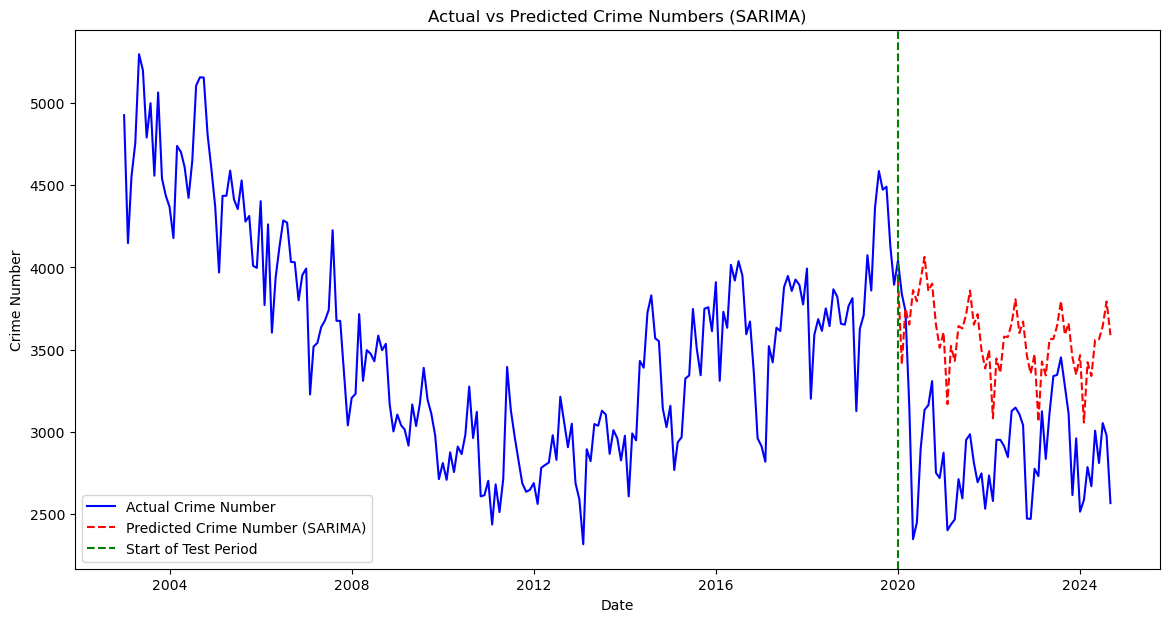

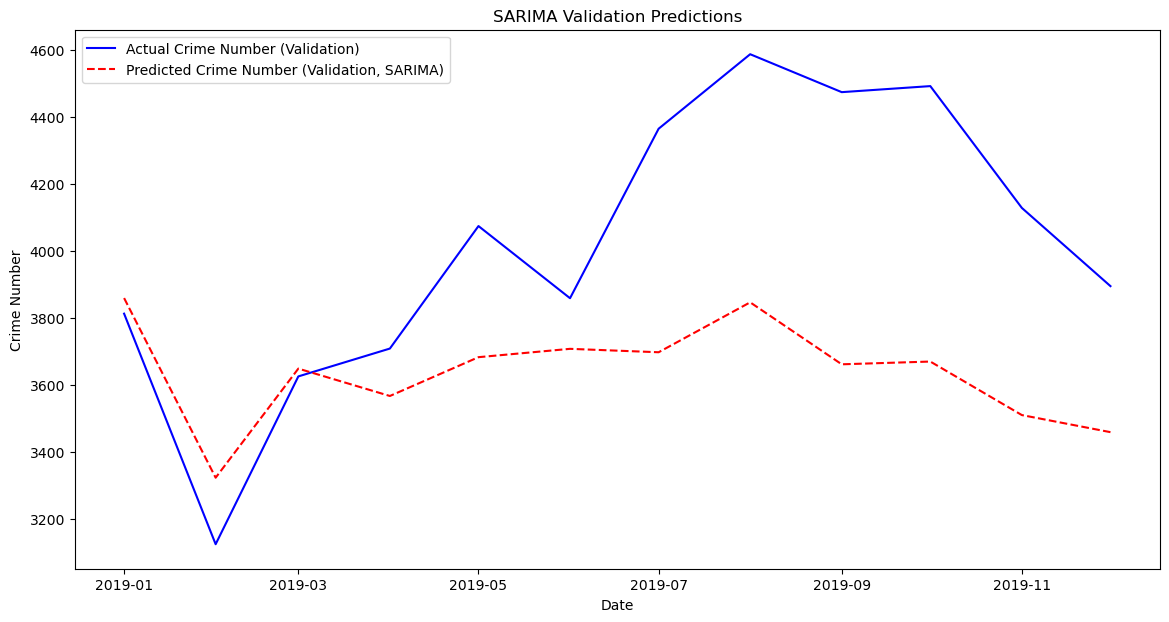

In [185]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import pandas as pd

train_data = merged_df_arima[(merged_df_arima['date'] < '2019-01-01')]
val_data = merged_df_arima[(merged_df_arima['date'] >= '2019-01-01') & (merged_df_arima['date'] < '2020-01-01')]

crime_series_train = train_data.set_index('date')['crime_number'].asfreq('MS')
crime_series_val = val_data.set_index('date')['crime_number'].asfreq('MS')

sarima_model = SARIMAX(crime_series_train, order=(1, 0, 0), seasonal_order=(1, 1, 1, 12)).fit(disp=False)

forecast_val = sarima_model.predict(start=crime_series_val.index[0], end=crime_series_val.index[-1], dynamic=True)

mape_val = mean_absolute_percentage_error(crime_series_val, forecast_val)
print(f"Validation MAPE: {mape_val * 100:.2f}%")

full_train_data = merged_df_arima[merged_df_arima['date'] < '2020-01-01'].set_index('date')['crime_number'].asfreq('MS')
sarima_model_full = SARIMAX(full_train_data, order=(1, 0, 0), seasonal_order=(1, 1, 1, 12)).fit(disp=False)

forecast_start = '2020-01-01'
forecast_end = merged_df_arima['date'].max()
forecast_test = sarima_model_full.predict(start=forecast_start, end=forecast_end, dynamic=True)

forecast_test_df = forecast_test.reset_index()
forecast_test_df.columns = ['date', 'predicted_crime_number_arima']
merged_df_arima = pd.merge(merged_df_arima, forecast_test_df, how='left', on='date')

plt.figure(figsize=(14, 7))
plt.plot(merged_df_arima['date'], merged_df_arima['crime_number'], label="Actual Crime Number", color="blue")
plt.plot(merged_df_arima['date'], merged_df_arima['predicted_crime_number_arima'], label="Predicted Crime Number (SARIMA)", color="red", linestyle="--")
plt.axvline(x=pd.to_datetime('2020-01-01'), color='green', linestyle='--', label='Start of Test Period')
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Actual vs Predicted Crime Numbers (SARIMA)")
plt.legend()
plt.show()


plt.figure(figsize=(14, 7))
plt.plot(crime_series_val.index, crime_series_val, label="Actual Crime Number (Validation)", color="blue")
plt.plot(crime_series_val.index, forecast_val, label="Predicted Crime Number (Validation, SARIMA)", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("SARIMA Validation Predictions")
plt.legend()
plt.show()



Test MAPE: 25.31%
Average percent difference after 2020-03-01: -25.31%


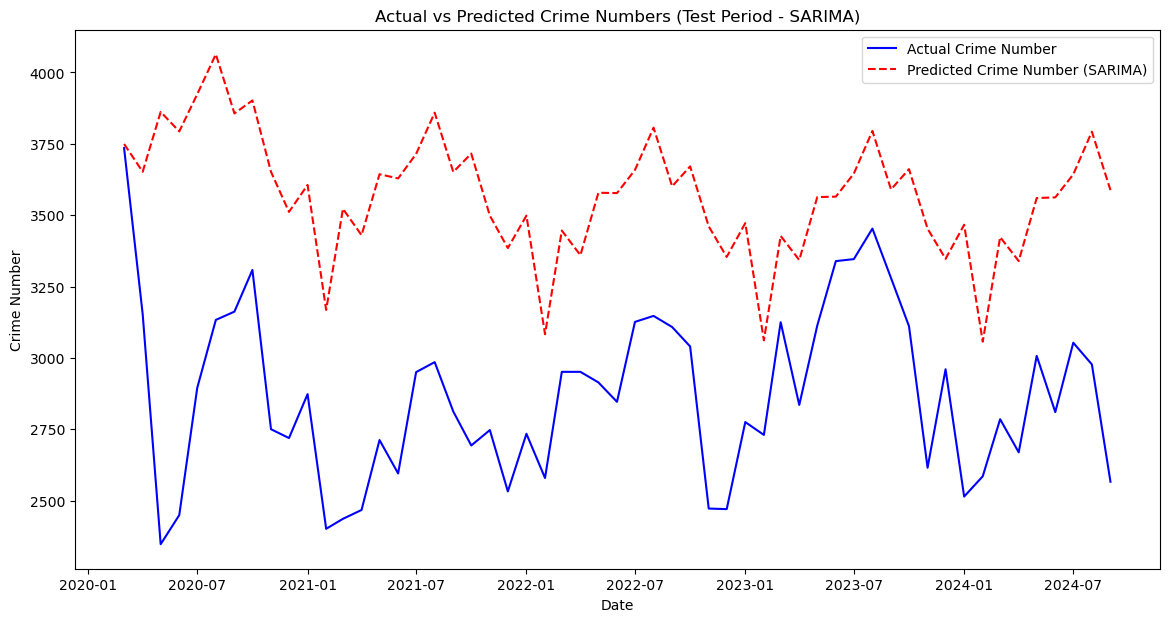

In [186]:
from sklearn.metrics import mean_absolute_percentage_error

test_data_actual = merged_df_arima.loc[merged_df_arima['date'] >= '2020-03-01', 'crime_number']
test_data_predicted = merged_df_arima.loc[merged_df_arima['date'] >= '2020-03-01', 'predicted_crime_number_arima']

valid_indices = test_data_actual.notna() & test_data_predicted.notna()
test_data_actual = test_data_actual[valid_indices]
test_data_predicted = test_data_predicted[valid_indices]

mape_test = mean_absolute_percentage_error(test_data_actual, test_data_predicted)
print(f"Test MAPE: {mape_test * 100:.2f}%")

percent_diff = ((test_data_actual - test_data_predicted) / test_data_actual).mean() * 100
print(f"Average percent difference after 2020-03-01: {percent_diff:.2f}%")

plt.figure(figsize=(14, 7))
plt.plot(merged_df_arima.loc[merged_df_arima['date'] >= '2020-03-01', 'date'], test_data_actual, label="Actual Crime Number", color="blue")
plt.plot(merged_df_arima.loc[merged_df_arima['date'] >= '2020-03-01', 'date'], test_data_predicted, label="Predicted Crime Number (SARIMA)", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Actual vs Predicted Crime Numbers (Test Period - SARIMA)")
plt.legend()
plt.show()


## Method 2: XGBoost

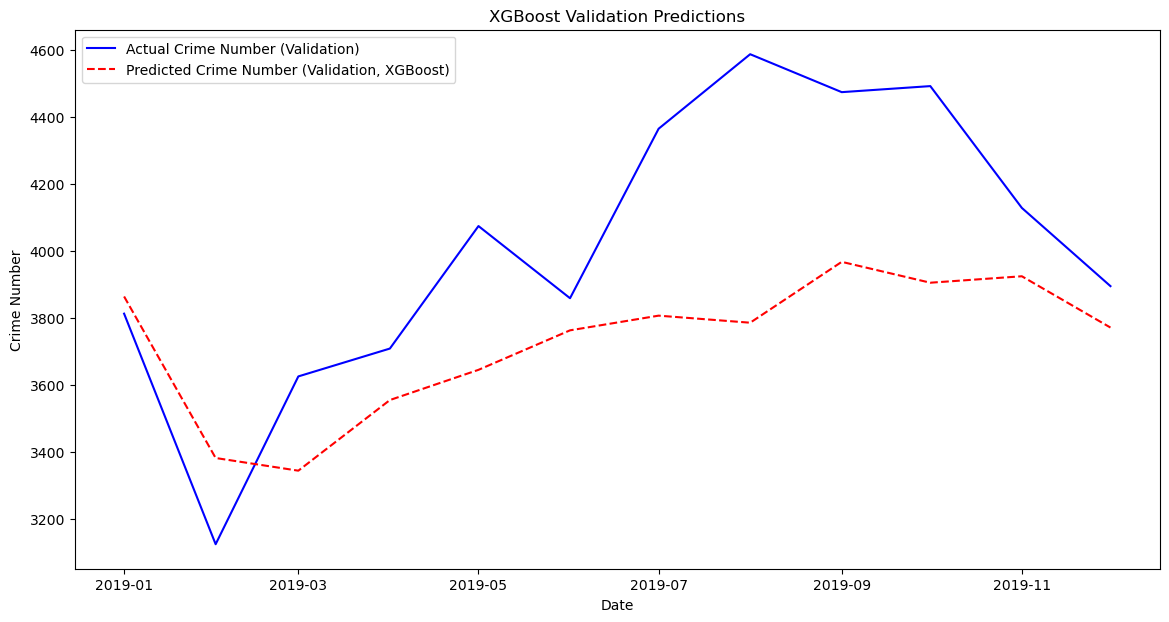

Validation MAPE: 8.09%


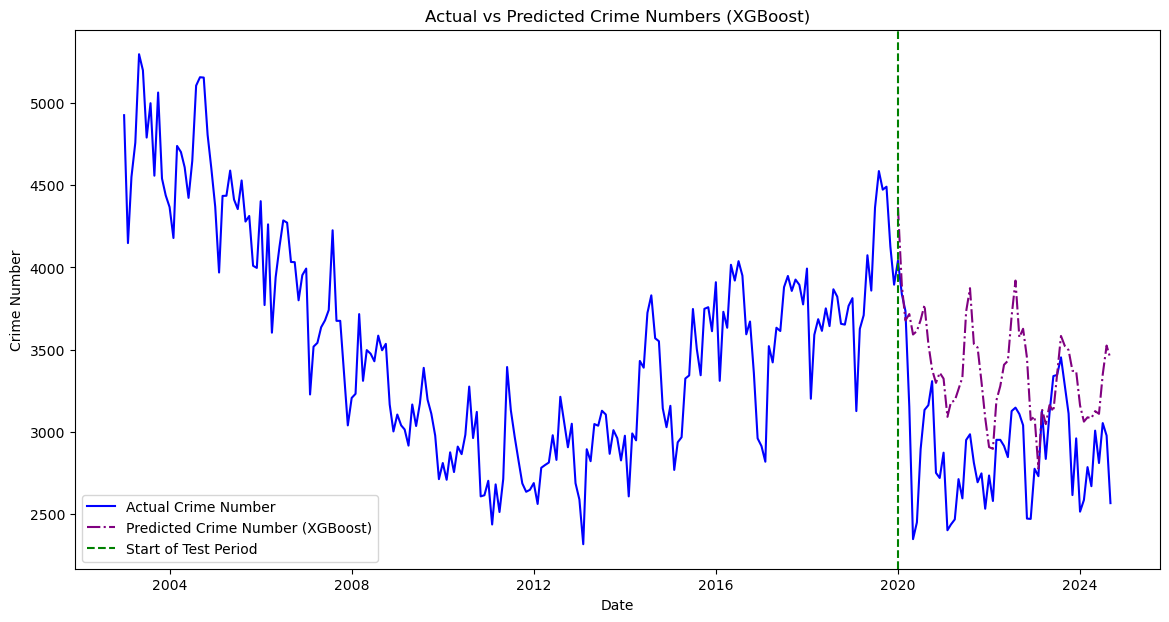

In [187]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

def create_lagged_features(df, target_col, lags):
    df = df.copy()
    for lag in range(1, lags + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

train_data = merged_df_xgb[merged_df_xgb['date'] < '2019-01-01']
val_data = merged_df_xgb[(merged_df_xgb['date'] >= '2019-01-01') & (merged_df_xgb['date'] < '2020-01-01')]

train_data = create_lagged_features(train_data, 'crime_number', 3)
val_data = create_lagged_features(val_data, 'crime_number', 3)

val_data.fillna(method='ffill', inplace=True)
val_data.fillna(val_data.mean(numeric_only=True), inplace=True)

train_data['month'] = train_data['date'].dt.month
train_data['year'] = train_data['date'].dt.year
val_data['month'] = val_data['date'].dt.month
val_data['year'] = val_data['date'].dt.year

features = [
    'crime_number_lag_1', 'crime_number_lag_2', 'crime_number_lag_3',
    'month', 'year', 'Police officers per 100,000 population',
    'Weighted clearance rate', 'Vancouver Unemployment Rate',
    'CPI', 'MinWage', 'temperature'
]
X_train = train_data[features]
y_train = train_data['crime_number']
X_val = val_data[features]
y_val = val_data['crime_number']

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

val_predictions = xgb_model.predict(X_val)

plt.figure(figsize=(14, 7))

plt.plot(val_data['date'], y_val, label="Actual Crime Number (Validation)", color="blue")
plt.plot(val_data['date'], val_predictions, label="Predicted Crime Number (Validation, XGBoost)", color="red", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("XGBoost Validation Predictions")
plt.legend()
plt.show()

mape_val = mean_absolute_percentage_error(y_val, val_predictions)
print(f"Validation MAPE: {mape_val * 100:.2f}%")

full_train_data = merged_df_xgb[merged_df_xgb['date'] < '2020-01-01']
full_train_data = create_lagged_features(full_train_data, 'crime_number', 3).fillna(method='ffill').fillna(full_train_data.mean(numeric_only=True))
full_train_data['month'] = full_train_data['date'].dt.month
full_train_data['year'] = full_train_data['date'].dt.year

X_full_train = full_train_data[features]
y_full_train = full_train_data['crime_number']


xgb_model.fit(X_full_train, y_full_train)


test_data = merged_df_xgb[merged_df_xgb['date'] >= '2020-01-01'].copy()
test_data = create_lagged_features(test_data, 'crime_number', 3).fillna(method='ffill').fillna(test_data.mean(numeric_only=True))
test_data['month'] = test_data['date'].dt.month
test_data['year'] = test_data['date'].dt.year

test_predictions = []
for i in range(len(test_data)):
    X_test_row = test_data[features].iloc[i].values.reshape(1, -1)
    pred = xgb_model.predict(X_test_row)[0]
    test_predictions.append(pred)

    if i + 1 < len(test_data):
        test_data.loc[test_data.index[i + 1], 'crime_number_lag_1'] = pred
        test_data.loc[test_data.index[i + 1], 'crime_number_lag_2'] = test_data.loc[test_data.index[i], 'crime_number_lag_1']
        test_data.loc[test_data.index[i + 1], 'crime_number_lag_3'] = test_data.loc[test_data.index[i], 'crime_number_lag_2']

test_data['predicted_crime_number_xgb'] = test_predictions

merged_df_xgb = pd.merge(merged_df_xgb, test_data[['date', 'predicted_crime_number_xgb']], how='left', on='date')

plt.figure(figsize=(14, 7))
plt.plot(merged_df_xgb['date'], merged_df_xgb['crime_number'], label="Actual Crime Number", color="blue")
plt.plot(merged_df_xgb['date'], merged_df_xgb['predicted_crime_number_xgb'], label="Predicted Crime Number (XGBoost)", color="purple", linestyle="-.")
plt.axvline(x=pd.to_datetime('2020-01-01'), color='green', linestyle='--', label='Start of Test Period')
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Actual vs Predicted Crime Numbers (XGBoost)")
plt.legend()
plt.show()



Test MAPE: 18.03%
Average percent difference after 2020-03-01: -17.74%


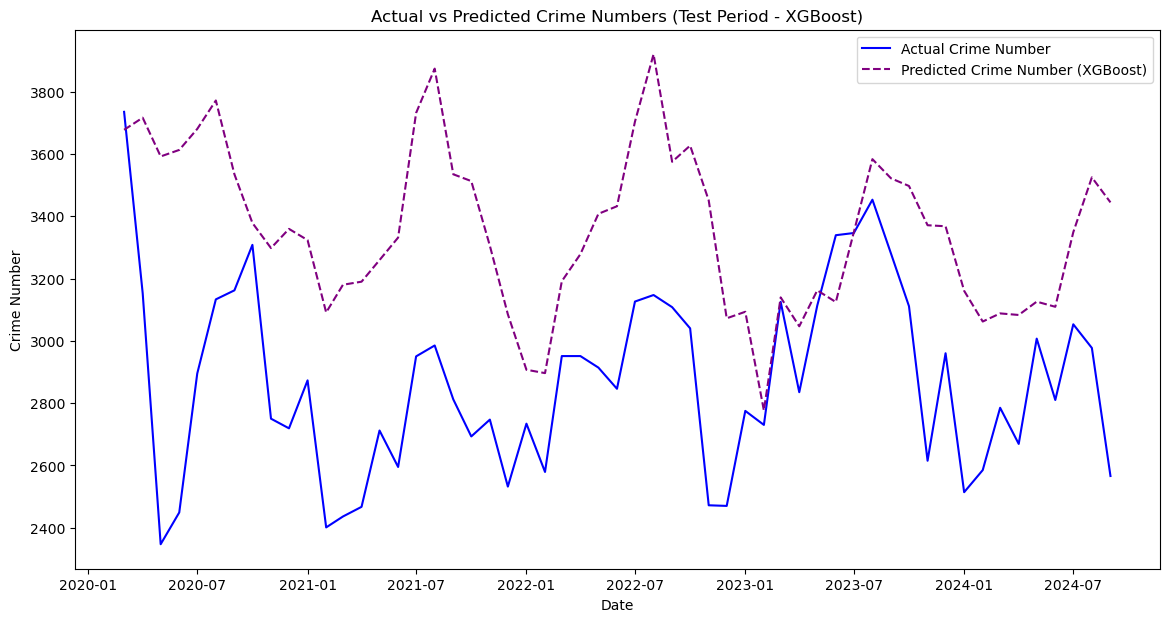

In [188]:
from sklearn.metrics import mean_absolute_percentage_error


# Filter test data after 2020-03-01 (real test data period)
test_data_actual = merged_df_xgb.loc[merged_df_xgb['date'] >= '2020-03-01', 'crime_number']
test_data_predicted = merged_df_xgb.loc[merged_df_xgb['date'] >= '2020-03-01', 'predicted_crime_number_xgb']

# Drop NaN values
valid_indices = test_data_actual.notna() & test_data_predicted.notna()
test_data_actual = test_data_actual[valid_indices]
test_data_predicted = test_data_predicted[valid_indices]

# Calculate MAPE
mape_test = mean_absolute_percentage_error(test_data_actual, test_data_predicted)
print(f"Test MAPE: {mape_test * 100:.2f}%")

# Calculate percentage difference
percent_diff = ((test_data_actual - test_data_predicted) / test_data_actual).mean() * 100
print(f"Average percent difference after 2020-03-01: {percent_diff:.2f}%")

# Optional: Visualize actual vs predicted values for the test period
plt.figure(figsize=(14, 7))
plt.plot(merged_df_xgb.loc[merged_df_xgb['date'] >= '2020-03-01', 'date'], test_data_actual, label="Actual Crime Number", color="blue")
plt.plot(merged_df_xgb.loc[merged_df_xgb['date'] >= '2020-03-01', 'date'], test_data_predicted, label="Predicted Crime Number (XGBoost)", color="purple", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Actual vs Predicted Crime Numbers (Test Period - XGBoost)")
plt.legend()
plt.show()


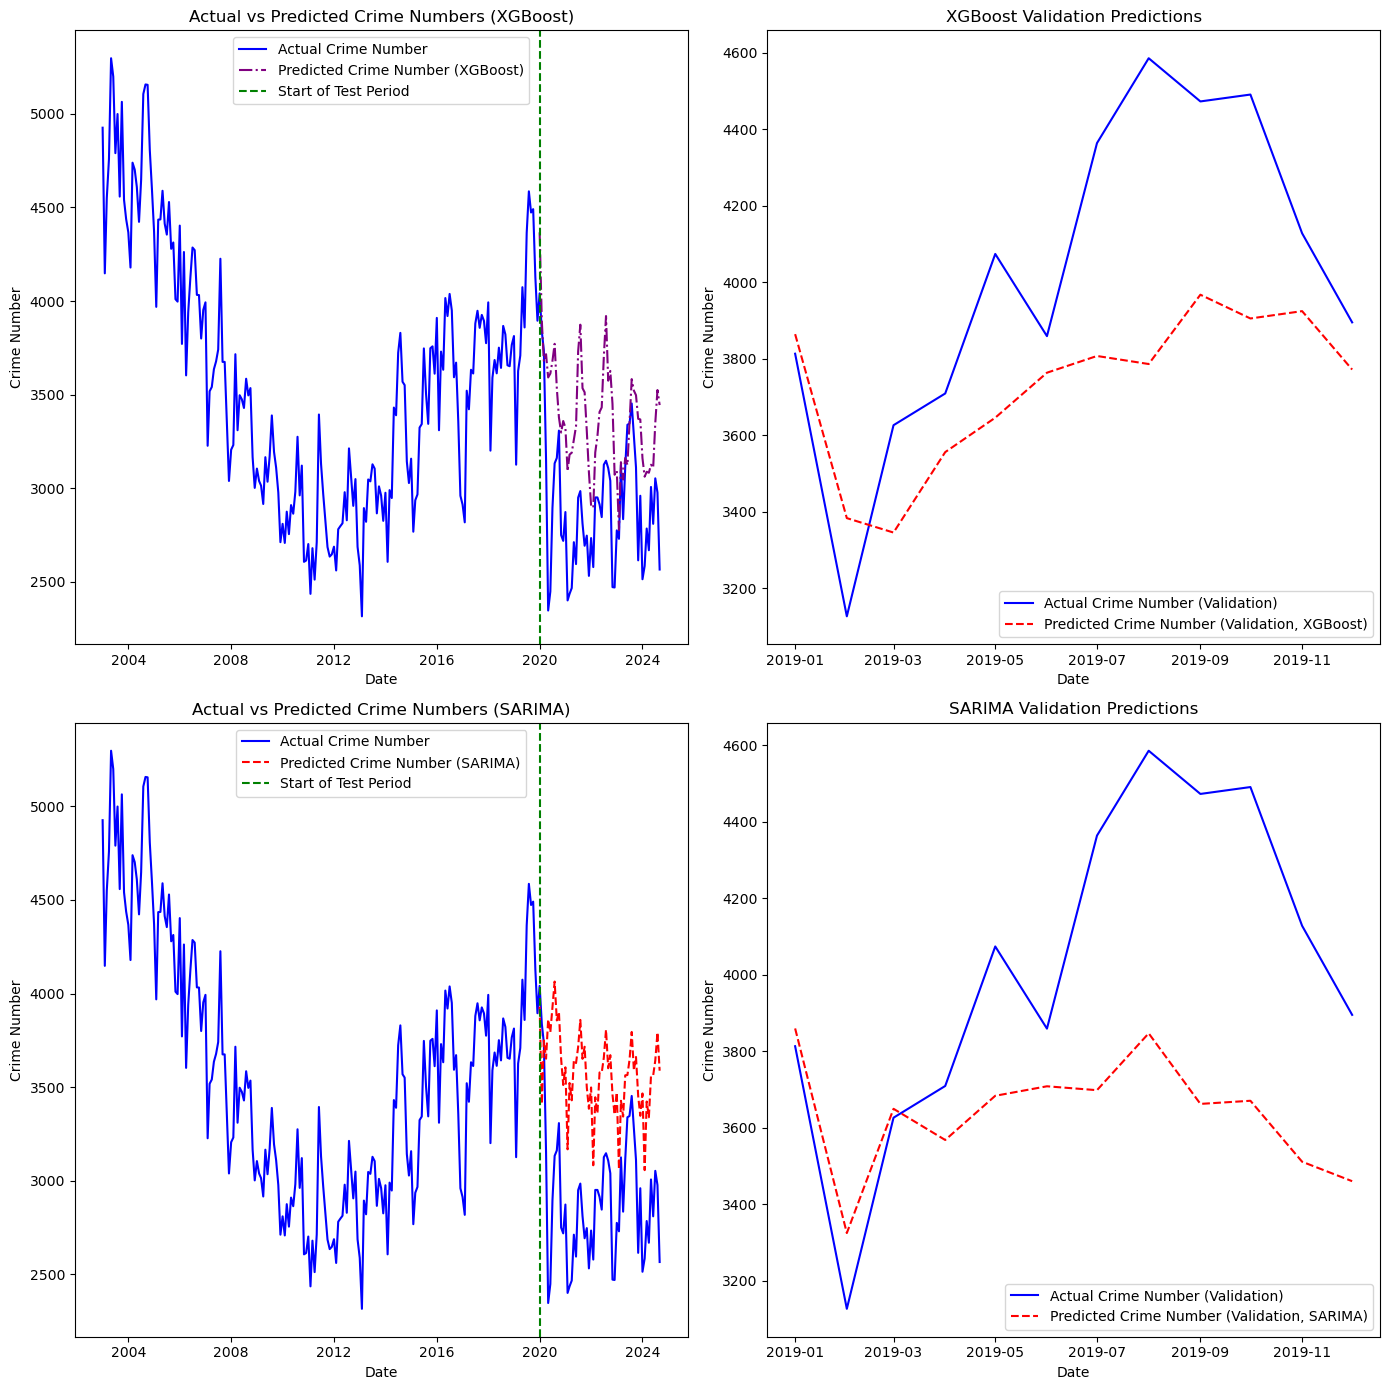

In [189]:
 # put Actual vs Predicted Crime Numbers (XGBoost), XGBoost Validation Predictions, Actual vs Predicted Crime Numbers (SARIMA), SARIMA Validation Predictions in
# 1 figure with 4 subplots
plt.figure(figsize=(14, 14))

# Actual vs Predicted Crime Numbers (XGBoost)
plt.subplot(2, 2, 1)

plt.plot(merged_df_xgb['date'], merged_df_xgb['crime_number'], label="Actual Crime Number", color="blue")
plt.plot(merged_df_xgb['date'], merged_df_xgb['predicted_crime_number_xgb'], label="Predicted Crime Number (XGBoost)", color="purple", linestyle="-.")
plt.axvline(x=pd.to_datetime('2020-01-01'), color='green', linestyle='--', label='Start of Test Period')
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Actual vs Predicted Crime Numbers (XGBoost)")
plt.legend()

# XGBoost Validation Predictions
plt.subplot(2, 2, 2)

plt.plot(val_data['date'], y_val, label="Actual Crime Number (Validation)", color="blue")
plt.plot(val_data['date'], val_predictions, label="Predicted Crime Number (Validation, XGBoost)", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("XGBoost Validation Predictions")
plt.legend()

# Actual vs Predicted Crime Numbers (SARIMA)
plt.subplot(2, 2, 3)

plt.plot(merged_df_arima['date'], merged_df_arima['crime_number'], label="Actual Crime Number", color="blue")
plt.plot(merged_df_arima['date'], merged_df_arima['predicted_crime_number_arima'], label="Predicted Crime Number (SARIMA)", color="red", linestyle="--")
plt.axvline(x=pd.to_datetime('2020-01-01'), color='green', linestyle='--', label='Start of Test Period')
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Actual vs Predicted Crime Numbers (SARIMA)")
plt.legend()

# SARIMA Validation Predictions
plt.subplot(2, 2, 4)

plt.plot(val_data['date'], y_val, label="Actual Crime Number (Validation)", color="blue")
plt.plot(val_data['date'], forecast_val, label="Predicted Crime Number (Validation, SARIMA)", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("SARIMA Validation Predictions")
plt.legend()

plt.tight_layout()
plt.show()

In [190]:
# train a new xgboost model doing feature selection, try out different combinations of features and see which one gives the best result
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

# Define the features and target variable
features = [
    'crime_number_lag_1', 'crime_number_lag_2', 'crime_number_lag_3',
    'month', 'year', 'Police officers per 100,000 population',
    'Weighted clearance rate', 'Vancouver Unemployment Rate',
    'CPI', 'MinWage', 'temperature'
]

X = full_train_data[features]
y = full_train_data['crime_number']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the xgboost model
rf_model = RandomForestRegressor(random_state=42)


# Initialize RFECV
rfecv = RFECV(estimator=rf_model, step=1, cv=5, scoring='neg_mean_absolute_percentage_error')

# Fit RFECV
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Print the selected features
print("Selected Features:")
print(selected_features)

# print mapes for selected features
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

rf_model.fit(X_train_selected, y_train)

val_predictions = rf_model.predict(X_val_selected)

mape_val = mean_absolute_percentage_error(y_val, val_predictions)
print(f"Validation MAPE: {mape_val * 100:.2f}%")



Selected Features:
Index(['crime_number_lag_1', 'crime_number_lag_2', 'crime_number_lag_3',
       'month', 'year', 'Weighted clearance rate',
       'Vancouver Unemployment Rate', 'CPI', 'temperature'],
      dtype='object')
Validation MAPE: 4.75%


In [191]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error

# Use selected features for training and validation
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model on the selected features
xgb_model.fit(X_train_selected, y_train)

# Make predictions on the validation set
val_predictions = xgb_model.predict(X_val_selected)

# Calculate MAPE
mape_val = mean_absolute_percentage_error(y_val, val_predictions)
print(f"Validation MAPE (XGBoost with selected features): {mape_val * 100:.2f}%")


Validation MAPE (XGBoost with selected features): 4.28%


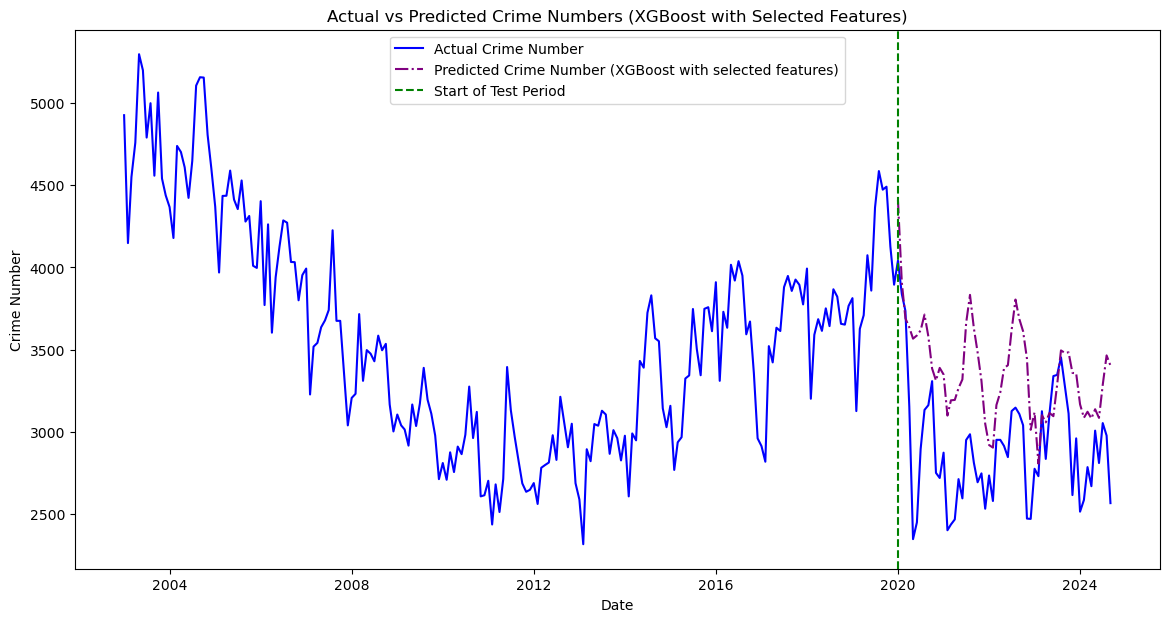

Test MAPE (XGBoost with selected features): 17.64%


In [192]:
# do the same thing for code block 116, 117 but using xgboost with selected features
full_train_data_selected = full_train_data[selected_features]

X_full_train_selected = full_train_data_selected
y_full_train = full_train_data['crime_number']

xgb_model.fit(X_full_train_selected, y_full_train)

test_data_selected = test_data[selected_features]

test_predictions = xgb_model.predict(test_data_selected)

test_data['predicted_crime_number_xgb_selected'] = test_predictions

merged_df_xgb = pd.merge(merged_df_xgb, test_data[['date', 'predicted_crime_number_xgb_selected']], how='left', on='date')

plt.figure(figsize=(14, 7))
plt.plot(merged_df_xgb['date'], merged_df_xgb['crime_number'], label="Actual Crime Number", color="blue")
plt.plot(merged_df_xgb['date'], merged_df_xgb['predicted_crime_number_xgb_selected'], label="Predicted Crime Number (XGBoost with selected features)", color="purple", linestyle="-.")
plt.axvline(x=pd.to_datetime('2020-01-01'), color='green', linestyle='--', label='Start of Test Period')
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Actual vs Predicted Crime Numbers (XGBoost with Selected Features)")
plt.legend()

plt.show()

# calculate MAPE for the test period
test_data_actual = merged_df_xgb.loc[merged_df_xgb['date'] >= '2020-03-01', 'crime_number']
test_data_predicted = merged_df_xgb.loc[merged_df_xgb['date'] >= '2020-03-01', 'predicted_crime_number_xgb_selected']

valid_indices = test_data_actual.notna() & test_data_predicted.notna()
test_data_actual = test_data_actual[valid_indices]
test_data_predicted = test_data_predicted[valid_indices]

mape_test = mean_absolute_percentage_error(test_data_actual, test_data_predicted)

print(f"Test MAPE (XGBoost with selected features): {mape_test * 100:.2f}%")

